<center>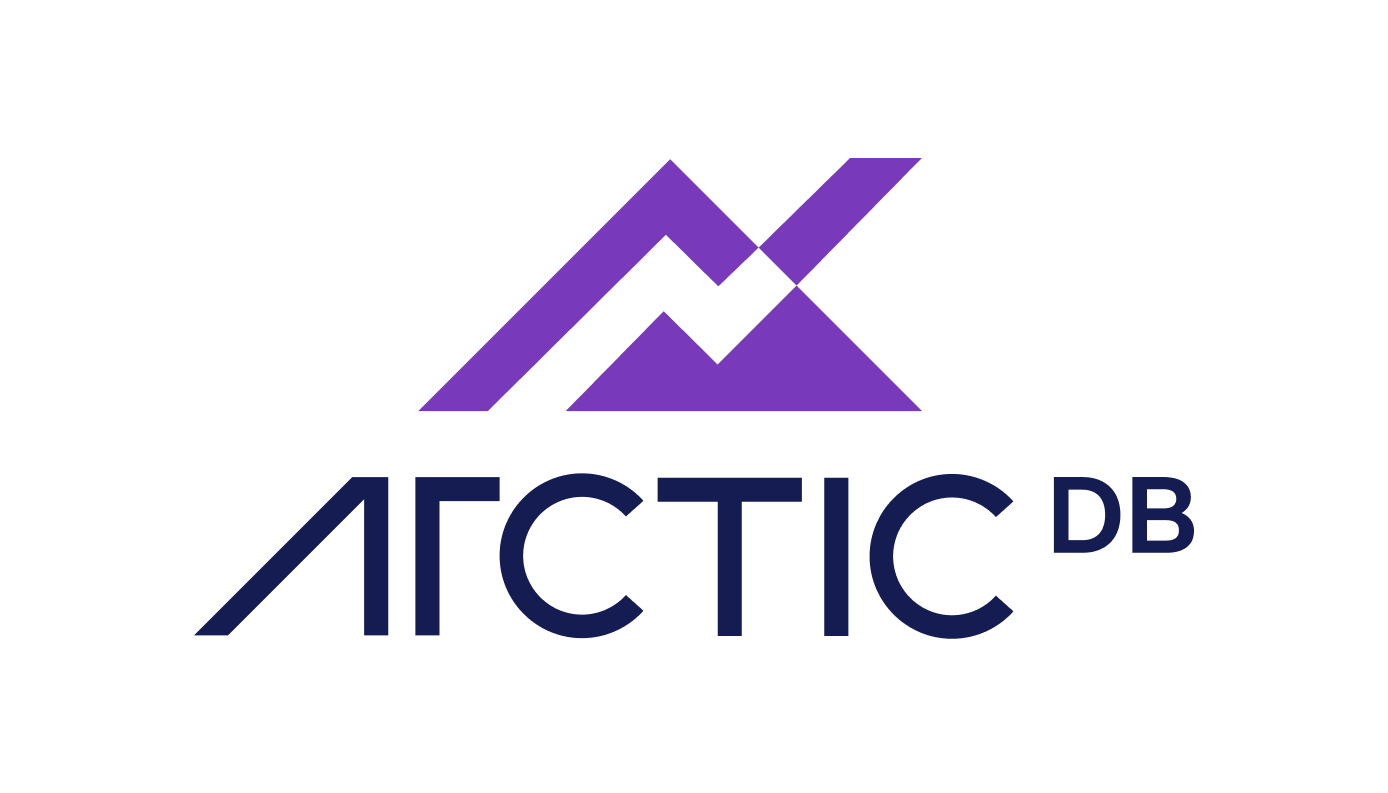
</center>

# ArcticDB Recursive Normalizers Demo

This notebook demonstrates the **recursive normalizers** feature in ArcticDB, which allows you to write nested data structures without having to pickle the entire object.

## What are Recursive Normalizers?

Recursive normalizers enable ArcticDB to:
- Write and read nested data structures (dicts, lists, tuples) containing DataFrames and arrays
- Store each component efficiently without pickling the entire structure

## Setup

### Meta structure V2

Meta structure V2 for recursive normalizer is introduced in v6.7.0. It has removed the dependency on pickle for normalizing the meta structure.
Please consider enabling V2 as V1 will be deprecated in future v7.0.0 release. To enabld it, you need to set environment variable **ARCTICDB_VersionStore_RecursiveNormalizerMetastructure_int** to **2**.

Reader of the data is needed to be >= v6.7.0 or **KeyError** will be raised while reading V2 meta structure

### Imports

In [ ]:
import numpy as np
import pandas as pd
import arcticdb as adb
from arcticdb.util.test import equals

In [3]:
# Create Arctic instance with LMDB backend
arctic = adb.Arctic("lmdb://recursive_normalizers_demo")

lib = arctic.get_library("demo", create_if_missing=True)

## Basic Example: Writing Dict Data

Let's start with a simple example of writing a dictionary containing DataFrames and arrays.

In [4]:
# Create sample data
df1 = pd.DataFrame({"col1": [1, 2, 3], "col2": ["a", "b", "c"]})
df2 = pd.DataFrame({"value": [10, 20, 30]})
array = np.arange(5)

# Create nested structure
nested_data = {
    "dataframe1": df1,
    "dataframe2": df2,
    "array": array,
    "metadata": {"description": "Sample nested data"}
}

print("Original nested data:")
print(nested_data)

Original nested data:
{'dataframe1':    col1 col2
0     1    a
1     2    b
2     3    c, 'dataframe2':    value
0     10
1     20
2     30, 'array': array([0, 1, 2, 3, 4]), 'metadata': {'description': 'Sample nested data'}}


### Writing Without Recursive Normalizers (Will Fail)

By default, ArcticDB cannot write nested structures without pickling:

In [5]:
# This will raise an exception, recursive_normalizers is False by default
try:
    lib.write("nested_data_fail", nested_data)
except Exception as e:
    print(f"Exception thrown: {e}")

Exception thrown: Data is of a type that cannot be normalized. Consider using write_pickle instead. type(data)=[<class 'dict'>]


### Writing With Recursive Normalizers (Success)

Enable recursive normalizers to write the nested structure:

In [6]:
# Write with recursive normalizers enabled
lib.write("nested_data_success", nested_data, recursive_normalizers=True)
print("Successfully written!")

# Read it back
result = lib.read("nested_data_success").data

# Verify the data matches the original
equals(nested_data, result)
print("\nAssertion passed: Read data matches original nested_data!")

Successfully written!

Assertion passed: Read data matches original nested_data!


## Example: Lists and Tuples

Recursive normalizers also work with lists and tuples:

In [7]:
# Create list of DataFrames
list_data = [
    pd.DataFrame({"a": [1, 2, 3]}),
    pd.DataFrame({"b": [4, 5, 6]}),
    np.array([7, 8, 9])
]

lib.write("list_data", list_data, recursive_normalizers=True)
result = lib.read("list_data").data

# Verify the data matches
equals(list_data, result)
print("List data successfully written and verified!")

List data successfully written and verified!


In [8]:
# Create tuple of mixed data
tuple_data = (
    np.arange(5),
    pd.DataFrame({"col": [1, 2, 3]}),
    {"nested": np.arange(3)}
)

lib.write("tuple_data", tuple_data, recursive_normalizers=True)
result = lib.read("tuple_data").data

# Verify the data matches
equals(tuple_data, result)
print("Tuple data successfully written and verified!")

Tuple data successfully written and verified!


## Example: Nested Structures

Recursive normalizers can handle nested structures:

In [9]:
# Create nested structure
nested = {
    "level1": {
        "level2": {
            "level3": {
                "dataframe": pd.DataFrame({"x": [1, 2, 3]}),
                "array": np.arange(10)
            }
        }
    },
    "another_branch": [
        pd.DataFrame({"y": [4, 5, 6]}),
        {"nested_dict": np.array([7, 8, 9])}
    ]
}

lib.write("nested", nested, recursive_normalizers=True)
result = lib.read("nested").data

# Verify the data matches
equals(nested, result)
print("Nested structure successfully written and verified!")

Nested structure successfully written and verified!


## Enable Recursive Normalizer in Library Configuration
You can configure recursive normalizers at the library configuration instead of specifying it for each write:

### Modifying Library Options

You can modify an existing library's configuration:

In [10]:
# Enable recursive normalizers for existing library
from arcticdb_ext.storage import ModifiableLibraryOption
arctic.modify_library_option(lib, ModifiableLibraryOption.RECURSIVE_NORMALIZERS, True)

# Now writes will enable recursive normalizers by default
data = {"df": pd.DataFrame({"b": [4, 5, 6]}), "arr": np.arange(3)}
lib.write("modified_lib_write", data)

result = lib.read("modified_lib_write").data
equals(data, result)
print("Data written successfully after modifying library option and verified!")

2025-11-21 13:07:07,890 INFO  [arcticdb.arctic] Set option=[ModifiableLibraryOption.RECURSIVE_NORMALIZERS] to value=[True] for Arctic=[Arctic(config=LMDB(path=/recursive_normalizers_demo))] Library=[Library(Arctic(config=LMDB(path=/recursive_normalizers_demo)), path=demo, storage=lmdb_storage)]


Data written successfully after modifying library option and verified!


### New Library
You can also create a new library with recursive normalizers enabled by default

In [11]:
# Create a new library with recursive normalizers enabled by default
lib_recursive = arctic.create_library("demo_recursive", library_options=adb.LibraryOptions(recursive_normalizers=True))

# Now you can write without specifying recursive_normalizers=True
data = {"df": pd.DataFrame({"a": [1, 2, 3]}), "arr": np.arange(5)}
lib_recursive.write("auto_recursive", data)

result = lib_recursive.read("auto_recursive").data
equals(data, result)
print("Data written successfully with library option enabled and verified!")

Data written successfully with library option enabled and verified!


## Using write_pickle with Recursive Normalizers

The `write_pickle` method can also use recursive normalizers. This is useful when you have nested structures with some components that cannot be natively normalized:

In [12]:
# Custom class that cannot be natively normalized
class CustomClass:
    def __init__(self, value):
        self.value = value
    
    def __eq__(self, other):
        return isinstance(other, CustomClass) and self.value == other.value

# Data with custom class
mixed_data = {
    "dataframe": pd.DataFrame({"a": [1, 2, 3]}),
    "array": np.arange(5),
    "custom": CustomClass(42)
}

# This will fail with regular write
try:
    lib.write("mixed_fail", mixed_data, recursive_normalizers=True)
except Exception as e:
    print(f"Error with write: {e}")

# But works with write_pickle
lib.write_pickle("mixed_success", mixed_data, recursive_normalizers=True)
result = lib.read("mixed_success").data

# Verify the data matches
equals(mixed_data, result)
print("Data written with write_pickle and verified! Data has been partially-pickled")

Error with write: Error while normalizing symbol=mixed_fail__custom, Normalizing data by pickling has been disabled.
Data written with write_pickle and verified! Data has been partially-pickled


## Exception Handling Examples

Let's explore various exceptions that can occur when using recursive normalizers:

### 1. ArcticUnsupportedDataTypeException

This exception occurs when trying to write nested data without enabling recursive normalizers:

In [13]:
from arcticdb.version_store.library import ArcticUnsupportedDataTypeException

data = {"df": pd.DataFrame({"a": [1, 2, 3]})}

try:
    lib.write("exception_test1", data, recursive_normalizers=False)
except ArcticUnsupportedDataTypeException as e:
    print("Caught ArcticUnsupportedDataTypeException:")
    print(f"Message: {str(e)}")
    print("\nSolution: Use recursive_normalizers=True or write_pickle")

Caught ArcticUnsupportedDataTypeException:
Message: Data is of a type that cannot be normalized. Consider using write_pickle instead. type(data)=[<class 'dict'>]

Solution: Use recursive_normalizers=True or write_pickle


### 2. DataTooNestedException

There's a limit to how deeply nested structures can be (255 levels):

In [14]:
from arcticdb.exceptions import DataTooNestedException

# Create a structure that's too deeply nested (256 levels)
def create_deep_nest(depth):
    if depth == 0:
        return pd.DataFrame({"a": [1, 2, 3]})
    return {"nested": create_deep_nest(depth - 1)}

try:
    too_deep = create_deep_nest(256)
    lib.write("exception_test3", too_deep, recursive_normalizers=True)
except DataTooNestedException as e:
    print("Caught DataTooNestedException:")
    print(f"Message: {str(e)}")
    print("\nSolution: Reduce nesting depth to 255 levels or less")

Caught DataTooNestedException:
Message: Symbol exception_test3 cannot be recursively normalized as it contains more than 255 levels of nested dictionaries. This is a limitation of the msgpack serializer.

Solution: Reduce nesting depth to 255 levels or less


### 3. SchemaException

Recursive normalized data cannot be filtered. Attempting to filter such data will raise a SchemaException.

In [16]:
from arcticdb.exceptions import SchemaException
from arcticdb.version_store.processing import QueryBuilder

# Try to filter recursively normalized data - this will fail
try:
    q = QueryBuilder()
    q = q[q["col"] == 0]
    lib.read("nested", query_builder=q)
except SchemaException as e:
    print("Caught SchemaException")
    print(f"Message: {str(e)}")
    print("\nSolution: Recursive normalized data cannot be filtered. Read the full data without filtering.")

try:
    lib.head("nested")
except SchemaException as e:
    print("Caught SchemaException again")


Caught SchemaException
Message: E_OPERATION_NOT_SUPPORTED_WITH_RECURSIVE_NORMALIZED_DATA Cannot filter recursively normalized data

Solution: Recursive normalized data cannot be filtered. Read the full data without filtering.
Caught SchemaException again


## Best Practices

1. **Use recursive normalizers for nested structures**: When you have dictionaries or lists containing DataFrames and arrays
2. **Configure at library level**: If you frequently write nested data, enable it at the library level
4. **Limit nesting depth**: Keep nesting under 255 levels
5. **Use write_pickle for mixed data**: When you have custom objects that can't be normalized
